# Machine Learning Exercise 12

# AlexNet - ARGOS


## Import 

Import libraries and print some versions.

To use GPU, set `Edit / Notebook settings / Hardware accelerator` to **GPU**.

In [11]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics
import tensorflow as tf
from keras import optimizers, regularizers
from keras.layers import (Activation, BatchNormalization, Conv2D, Dense,
                          Dropout, Flatten, MaxPooling2D)
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
print("Tensorflow version %s" %tf.__version__)
print("tf.Keras version %s" %tf.keras.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version 2.10.1
tf.Keras version 2.10.0
Found GPU at: /device:GPU:0


## Load data

Get data from  
https://drive.google.com/drive/folders/0Bxxqx_AAp2u2Zkp4cGxoNVEzb3M?resourcekey=0-RKOYOxuHZTxh0eSZRSnIoA

Place data in a Google folder and set the `datadir` variable below with the path of this folder.

Get Google Drive access

Load training data

4774 images from 20 classes



In [2]:
#from google.colab import drive -> We run it locally
#drive.mount('/content/drive')

#datadir = '/content/drive/MyDrive/Data/ARGOS_public'
datadir = 'C:/Users/Gianmarco/Università-Git/MachineLearning/test/Datasets/ARGOS_public'
trainingset = datadir+'/train/'
testset = datadir + '/test/'

batch_size = 32
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,\
    zoom_range=0.1,\
    rotation_range=10,\
    width_shift_range=0.1,\
    height_shift_range=0.1,\
    horizontal_flip=True,\
    vertical_flip=False)

train_generator = train_datagen.flow_from_directory(
    directory=trainingset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True)

test_datagen = ImageDataGenerator(
    rescale = 1. / 255)

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = [k for k,v in train_generator.class_indices.items()]

print("Image input %s" %str(input_shape))
print("Classes: %r" %classnames)

print('Loaded %d training samples from %d classes.' %(num_samples,num_classes))
print('Loaded %d test samples from %d classes.' %(test_generator.n,test_generator.num_classes))

Found 4774 images belonging to 20 classes.
Found 1686 images belonging to 20 classes.
Image input (118, 224, 3)
Classes: ['Acqua', 'Alilaguna', 'Ambulanza', 'Barchino', 'Cacciapesca', 'Caorlina', 'Gondola', 'Lancia', 'Motobarca', 'Motopontonerettangolare', 'MotoscafoACTV', 'Mototopo', 'Patanella', 'Polizia', 'Raccoltarifiuti', 'Sandoloaremi', 'Sanpierota', 'Topa', 'VaporettoACTV', 'VigilidelFuoco']
Loaded 4774 training samples from 20 classes.
Loaded 1686 test samples from 20 classes.


## Show *n* random images


VaporettoACTV


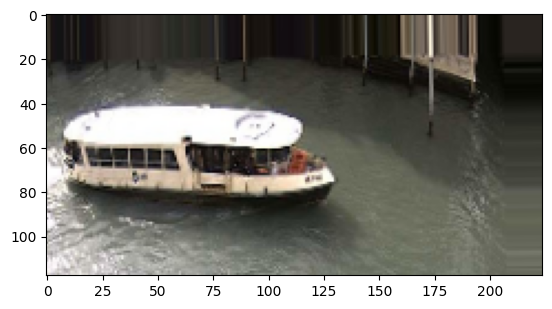

Mototopo


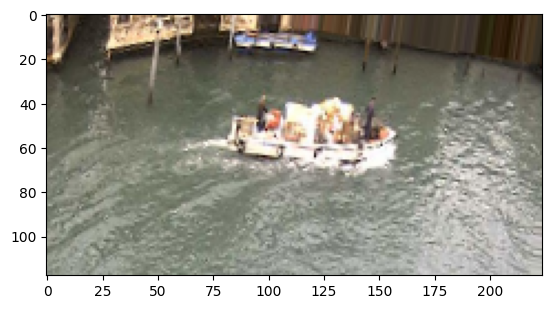

Mototopo


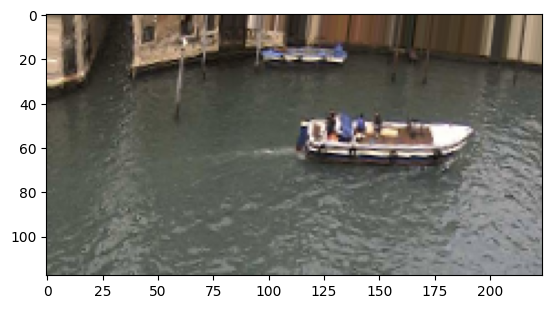

In [4]:
n = 3
x,y = train_generator.next()
# x,y size is train_generator.batch_size

for i in range(0,n):
    image = x[i]
    label = y[i].argmax()  # categorical from one-hot-encoding
    print(classnames[label])
    plt.imshow(image)
    plt.show()

## AlexNet

Create a new model inspired by AlexNet.

Note: if you want to load a pre-trained model on this dataset, go to next section.

In [13]:
def AlexNet(input_shape, num_classes, regl2 = 0.0001, lr=0.0001):

    model = Sequential()

    # C1 Convolutional Layer 
    model.add(Conv2D(filters=96, input_shape=input_shape, kernel_size=(11,11),\
                     strides=(2,4), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation before passing it to the next layer
    model.add(BatchNormalization())

    # C2 Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalization
    model.add(BatchNormalization())

    # C3 Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalization
    model.add(BatchNormalization())

    # C4 Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalization
    model.add(BatchNormalization())

    # C5 Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalization
    model.add(BatchNormalization())

    # Flatten
    model.add(Flatten())

    flatten_shape = (input_shape[0]*input_shape[1]*input_shape[2],)
    
    # D1 Dense Layer
    model.add(Dense(4096, input_shape=flatten_shape, kernel_regularizer=regularizers.l2(regl2)))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # D2 Dense Layer
    model.add(Dense(4096, kernel_regularizer=regularizers.l2(regl2)))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # D3 Dense Layer
    model.add(Dense(1000,kernel_regularizer=regularizers.l2(regl2)))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Output Layer
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # Compile

    adam = optimizers.Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model
 
# create the model
model = AlexNet(input_shape,num_classes)
model.summary()

# history of results (set to None when initializing a new mdoel)
history = None

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 54, 54, 96)        34944     
                                                                 
 activation_9 (Activation)   (None, 54, 54, 96)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 27, 27, 96)       384       
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 256)       2973952   
                                                                 
 activation_10 (Activation)  (None, 17, 17, 256)      

### Load a trained model

Load a model already trained on this data set (i.e., saved with save function show in the next section).

In [12]:
models_dir = datadir + '/models/'
loadepochs = 50
modelname = 'ARGOS-sc5-2013_20classes_alexnet_%d_epochs' %loadepochs

def loadmodel(problem):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    try:
        model = load_model(filename)
        print("\nModel loaded successfully from file %s\n" %filename)
    except OSError:    
        print("\nModel file %s not found!!!\n" %filename)
        model = None
    filename = os.path.join(models_dir, '%s_history.pkl' %problem)
    try:
        history = pickle.load(open(filename, "rb"))
        print("History loaded successfully from file %s\n" %filename)
    except OSError as e:
        print(e)
        print("History file %s not found!!!\n" %filename)
        history = None
    return model, history

model, history = loadmodel(modelname)


Model loaded successfully from file C:/Users/Gianmarco/Università-Git/MachineLearning/test/Datasets/ARGOS_public/models/ARGOS-sc5-2013_20classes_alexnet_50_epochs.h5

History loaded successfully from file C:/Users/Gianmarco/Università-Git/MachineLearning/test/Datasets/ARGOS_public/models/ARGOS-sc5-2013_20classes_alexnet_50_epochs_history.pkl



## Train

With GPU, training for 100 epochs takes about 2.5 hours, including model building and other initialization of the data generator happening in the first epoch.

Note: first epoch takes much longer for initialization and caching.

In [15]:
steps_per_epoch=train_generator.n//train_generator.batch_size
val_steps=test_generator.n//test_generator.batch_size+1

epochs = 20  # sets number of epochs

try:
    h = model.fit(train_generator, epochs=epochs, verbose=1,\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=test_generator,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass

# append current history

if history is None:
    history = h.history
else:
    history['loss'].extend(h.history['loss'])
    history['accuracy'].extend(h.history['accuracy'])
    history['val_loss'].extend(h.history['val_loss'])
    history['val_accuracy'].extend(h.history['val_accuracy'])

Epoch 1/20
149/149 [==============================] - 30s 196ms/step - loss: 1.5157 - accuracy: 0.7364 - val_loss: 1.9250 - val_accuracy: 0.6702
Epoch 2/20
149/149 [==============================] - 28s 189ms/step - loss: 1.4554 - accuracy: 0.7577 - val_loss: 3.4600 - val_accuracy: 0.2960
Epoch 3/20
149/149 [==============================] - 28s 188ms/step - loss: 1.4643 - accuracy: 0.7569 - val_loss: 2.0816 - val_accuracy: 0.6465
Epoch 4/20
149/149 [==============================] - 28s 190ms/step - loss: 1.4501 - accuracy: 0.7558 - val_loss: 2.0490 - val_accuracy: 0.6400
Epoch 5/20
149/149 [==============================] - 28s 189ms/step - loss: 1.3816 - accuracy: 0.7718 - val_loss: 1.3645 - val_accuracy: 0.7989
Epoch 6/20
149/149 [==============================] - 29s 193ms/step - loss: 1.3609 - accuracy: 0.7758 - val_loss: 1.4907 - val_accuracy: 0.7497
Epoch 7/20
149/149 [==============================] - 28s 191ms/step - loss: 1.4032 - accuracy: 0.7674 - val_loss: 1.7594 - val_ac

### Save model and history

In [ ]:
models_dir = datadir + '/models/'
modelname = 'ARGOS-sc5-2013_20classes_alexnet_%d_epochs' %len(history['loss'])

def savemodel(problem,model,history):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    model.save(filename)
    print("\nModel saved successfully on file %s\n" %filename)
    filename = os.path.join(models_dir, '%s_history.pkl' %problem)
    with open(filename, 'wb') as f:
        pickle.dump(history, f)
    print("History saved successfully on file %s\n" %filename)

# Save model and history
savemodel(modelname,model,history)


Model saved successfully on file /content/drive/MyDrive/Data/ARGOS_public/models/ARGOS-sc5-2013_20classes_alexnet_50_epochs.h5

History saved successfully on file /content/drive/MyDrive/Data/ARGOS_public/models/ARGOS-sc5-2013_20classes_alexnet_50_epochs_history.pkl



## Evaluate the model

Accuracy on test set

In [16]:
test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)
val_steps=test_generator.n//test_generator.batch_size+1
loss, acc = model.evaluate(test_generator,verbose=1,steps=val_steps)
print('Test loss: %f' %loss)
print('Test accuracy: %f' %acc)

Found 1686 images belonging to 20 classes.
53/53 [==============================] - 3s 54ms/step - loss: 1.4707 - accuracy: 0.7788
Test loss: 1.470716
Test accuracy: 0.778766


Precision, recall, F-score

In [17]:
val_steps=test_generator.n//test_generator.batch_size+1

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

preds = model.predict(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

print(classification_report(Ytest, Ypred, labels=None, target_names=classnames, digits=3))  

Found 1686 images belonging to 20 classes.
53/53 [==============================] - 3s 51ms/step
                         precision    recall  f1-score   support

                  Acqua      0.982     0.788     0.875       420
              Alilaguna      1.000     0.842     0.914        19
              Ambulanza      0.650     0.591     0.619        22
               Barchino      0.500     0.020     0.038        51
            Cacciapesca      0.000     0.000     0.000         1
               Caorlina      0.000     0.000     0.000         1
                Gondola      0.000     0.000     0.000         3
                 Lancia      0.661     0.972     0.787       355
              Motobarca      0.296     0.407     0.343        59
Motopontonerettangolare      0.750     1.000     0.857         3
          MotoscafoACTV      1.000     1.000     1.000         1
               Mototopo      0.965     0.676     0.795       284
              Patanella      0.506     0.581     0.541   

c:\Users\Gianmarco\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gianmarco\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gianmarco\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix analysis

In [ ]:
val_steps=test_generator.n//test_generator.batch_size+1

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

preds = model.predict_generator(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

cm = confusion_matrix(Ytest, Ypred)

conf = [] # data structure for confusions: list of (i,j,cm[i][j])
for i in range(0,cm.shape[0]):
  for j in range(0,cm.shape[1]):
    if (i!=j and cm[i][j]>0):
      conf.append([i,j,cm[i][j]])

col=2
conf = np.array(conf)
conf = conf[np.argsort(-conf[:,col])]  # decreasing order by 3-rd column (i.e., cm[i][j])

print('%-16s     %-16s  \t%s \t%s ' %('True','Predicted','errors','err %'))
print('------------------------------------------------------------------')
for k in conf:
  print('%-16s ->  %-16s  \t%d \t%.2f %% ' %(classnames[k[0]],classnames[k[1]],k[2],k[2]*100.0/test_generator.n))

Found 1686 images belonging to 20 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  from ipykernel import kernelapp as app


53/53 [==============================] - 10s 191ms/step
True                 Predicted         	errors 	err % 
------------------------------------------------------------------
Mototopo         ->  Motobarca         	61 	3.62 % 
Acqua            ->  Lancia            	23 	1.36 % 
Topa             ->  Patanella         	20 	1.19 % 
Barchino         ->  Patanella         	19 	1.13 % 
Acqua            ->  Patanella         	15 	0.89 % 
Barchino         ->  Lancia            	14 	0.83 % 
Patanella        ->  Lancia            	10 	0.59 % 
Motobarca        ->  Lancia            	9 	0.53 % 
Raccoltarifiuti  ->  Motobarca         	9 	0.53 % 
Lancia           ->  VigilidelFuoco    	6 	0.36 % 
Motobarca        ->  Patanella         	6 	0.36 % 
Mototopo         ->  Alilaguna         	6 	0.36 % 
Barchino         ->  Cacciapesca       	6 	0.36 % 
Topa             ->  Lancia            	6 	0.36 % 
Polizia          ->  Lancia            	5 	0.30 % 
Barchino         ->  Polizia           	5 	0.30 % 

### Plot results

Expected results with 100 epochs training

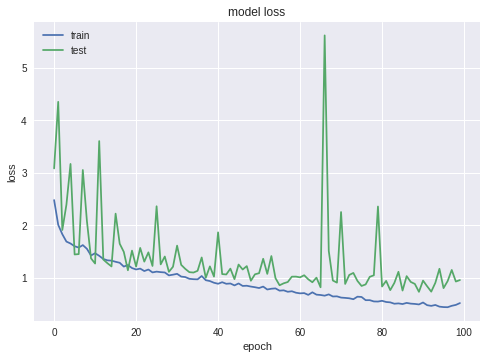



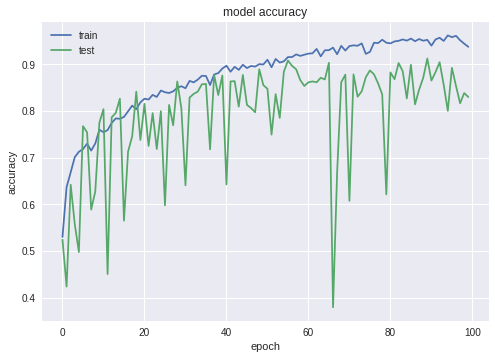



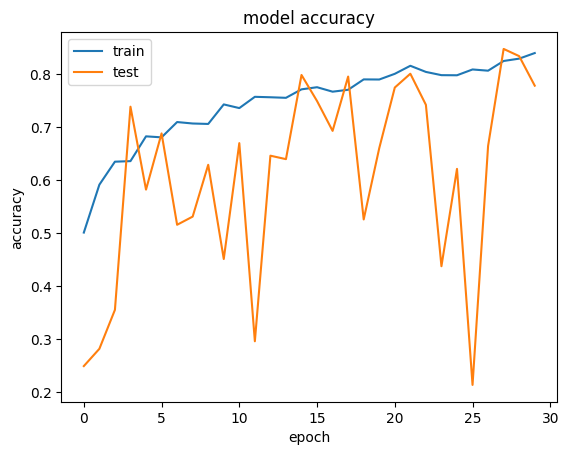

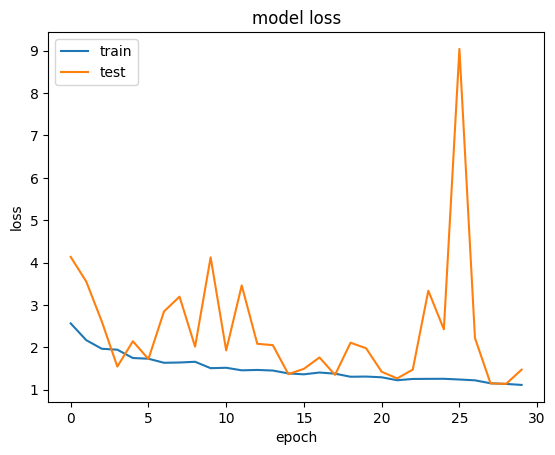

In [18]:
# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Home Exercises

**Question 1** 

Compare the model defined above with a model without all the regularization additions.
